# Projet 4 : Segmentez des clients d'un site de e-commerce
## Notebook de définitions du délai de mise à jour
Ce notebook sert à définir le delai entre deux mises à jour de la segmentation


### Contexte et objectifs
L'entreprise de e-commerce Olist souhaite comprendre les différents types de clients qu'elle possède. Elle souhaite donc ségmenter sa clientèle afin de pouvoir mieux communiquer en fonction du type de client. Pour cela elle souhaite classer les clients en fonction de leurs commandes passées ainsi que la satisfaction. 

### Modules Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn import preprocessing, metrics, cluster, decomposition
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import datetime

### Chargement du dataset


In [2]:
DATA = pd.read_csv("database_merge_cleaned.csv",sep=",", skipinitialspace=True, low_memory=False,\
                  parse_dates=[8], dayfirst=False)
print(f"Nombre de lignes : {len(DATA)}")
print(f"Nombre de variables : {len(DATA.columns)}")
print("Type des variables :")
print(DATA.dtypes)

Nombre de lignes : 111708
Nombre de variables : 14
Type des variables :
customer_id                         object
customer_unique_id                  object
customer_zip_code_prefix             int64
customer_city                       object
customer_state                      object
geolocation_lat                    float64
geolocation_lng                    float64
order_id                            object
order_purchase_timestamp    datetime64[ns]
review_score                       float64
order_item_id                      float64
product_id                          object
price                              float64
product_category_name               object
dtype: object


#### suppression des lignes non renseignées

In [3]:
for o_id in DATA[DATA['review_score'].isna()]["order_id"].unique() :
    DATA = DATA.drop(DATA.loc[DATA["order_id"]==o_id].index, inplace=False)

In [4]:
for o_id in DATA[DATA['order_item_id'].isna()]['order_id'].unique() :
    DATA = DATA.drop(DATA.loc[DATA["order_id"]==o_id].index, inplace=False)

In [5]:
for col in DATA.columns :
    print(f"{col} : {DATA[col].isna().sum()}")

customer_id : 0
customer_unique_id : 0
customer_zip_code_prefix : 0
customer_city : 0
customer_state : 0
geolocation_lat : 301
geolocation_lng : 301
order_id : 0
order_purchase_timestamp : 0
review_score : 0
order_item_id : 0
product_id : 0
price : 0
product_category_name : 1589


### Base de données initiale
La base de donnée initiale sera composée de toutes les données depuis la création de la base de données jusqu'à une date choisie arbitrairement.  
Le delai de mise à jour sera défini en ajoutant à cette période initiale des périodes de plus en plus longue pour déterminer le délai maximal entre deux mises à jour. 

In [6]:
print(f"Premier jour de la BDD : {DATA['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {DATA['order_purchase_timestamp'].max().date()}")

Premier jour de la BDD : 2016-09-04
Dernier jour de la BDD : 2018-09-03


Il a été décidé de prendre une période de 3 mois à l'origine de la base de donnée afin d'étudier le temps maximum avant de procéder à une mise à jour de la ségmentation.

In [7]:
def database_period(df, start=None, period=30) :
    """
    function to extract a period in the olist database
    t0 = start 
    tf = start+period (days)
    parameters : df : input DataFrame
                 start : first day
                 period : ndays
    returns : odf : filtered dataframe
    """
    #first_day = df['order_purchase_timestamp'].min().date
    date = df['order_purchase_timestamp'].apply(lambda x :x.date())
    if start is None :
        start = df['order_purchase_timestamp'].min().date()
    end = start + timedelta(days=period)
    odf = df[(date >= start) & (date <= end)]
    return odf

In [8]:
def transform_data(df):
    aggr = {
        'order_id' : lambda x : len(x.unique()), #Nombre de commande sur la période
        'days_orders' : lambda x : x.min(), #nombre de jour depuis la dernière commande
        'price' : ['sum', 'mean'],
        'product_id' : lambda x : len(x) #Nombre d'articles commandé
    }
    aggr_2 = {
        'price' : 'sum', #montant dépensé par commande
        'product_id': lambda x : len(x), #Nombre de produits par commande
        'review_score' : 'mean' #note par commande
    }
    aggr_3 = {
        'price' : 'mean', #prix moyen dépensé par commande
        'product_id': 'mean', #Nombre de produit moyen commandé
        'review_score' : 'mean' #Satisfaction moyenne
    }
    END = df['order_purchase_timestamp'].max().date()
    #df['days_orders'] = df["order_purchase_timestamp"].apply(lambda x : (END-x.date()).days)
    days_order = df["order_purchase_timestamp"].apply(lambda x : (END-x.date()).days).tolist()
    #print(days_order)
    df = pd.concat([df, pd.Series(data=days_order, index=df.index,name='days_orders')], axis=1)
    odf = df.groupby("customer_unique_id").agg(aggr)
    odf.rename(columns={"order_id": "n_orders"}, inplace=True)
    col = ["n_orders", "n_days_last_order", 'total_price', 'product_mean_price', "n_products"]
    odf.columns = col
    data_tmp = df.groupby(['customer_unique_id', 'order_id']).agg(aggr_2)
    data_tmp = data_tmp.groupby("customer_unique_id").agg(aggr_3)
    data_tmp.columns = ['mean_order_price', 'mean_n_products', 'mean_review_score']
    odf = pd.concat([odf, data_tmp], axis=1)
    #if scaler is None :
    return odf
    #else :
    #    return scaler.transform(odf)

In [9]:
tinit = 90
data_init = database_period(DATA, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")

Premier jour de la BDD : 2016-09-04
Dernier jour de la BDD : 2016-10-10


On remarque qu'aucune commande n'est enregistrée dans la base de données entre mi octobre et le mois de décembre.

In [10]:
data_init = transform_data(data_init)
cust_init = data_init.index
data_init.head()

,n_orders,n_days_last_order,total_price,product_mean_price,n_products,mean_order_price,mean_n_products,mean_review_score
customer_unique_id,,,,,,,,
0032c76b20340da25249092a268ce66c,1,4,128.90,128.90,1,128.90,1.0,4.0
01f156677184504063bd19739f924af1,1,0,739.98,739.98,1,739.98,1.0,5.0
0313291a6f4f16df04dcf819d88c38ef,1,1,95.00,95.00,1,95.00,1.0,1.0
0636d30c77f0f9cfad81f1c9b58c791f,1,2,949.99,949.99,1,949.99,1.0,4.0
0659f2d6cabae94afd4d009c6d0e07dc,1,1,390.00,195.00,2,390.00,2.0,1.0


#### Normalisation des données

In [11]:
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)

### classification initiale
Puisque la méthode AgglomerativeClustering ne permet pas de gérer la totalité de la BDD, on utilise la méthode KMeans avec 3 clusters

In [12]:
cls_init = KMeans(n_clusters=3, n_init=50, init='k-means++',random_state=42)
cls_init.fit(data_init_norm)
pred_init = pd.Series(index=cust_init, data=cls_init.predict(data_init_norm))

### Mesure de la similitude sur différentes périodes
#### recherche large
les périodes testées seront : 1, 7, 14, 30, 60, 90, 120, 180, 360  
Pour caractériser la similitude, les données de la nouvelle période seront normalisées avec le scaler initial et classifier avec le classifieur initial. Ensuite, les données seront à nouveau scaler et un nouveau classifieur sera créé. On calculera ensuite l'indice de rang ajuster pour comparer les deux ségmentations.

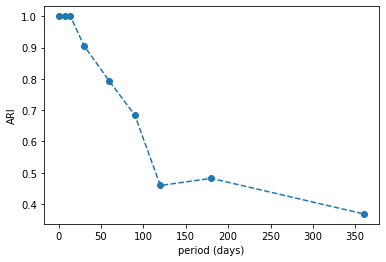

In [13]:
ARI = []
#periods = range(30, 160, 30)
periods = [1, 7, 14, 30, 60, 90, 120, 180, 360]
for days in periods:
    data_step = database_period(DATA, period=tinit+days)
    data_step = transform_data(data_step)
    #=======================================
    # classification avec le même classifieur
    #=======================================
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    #=======================================
    # classification avec un classifieur mis à jour
    #=======================================
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods,ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

Le nombre de changement dans la classification devient important à partir d'environ 2 ou 3 mois.  
Cela nous donne une première idée du délai optimal

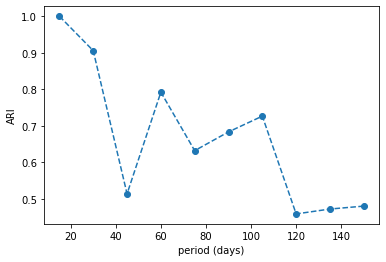

In [14]:
ARI = []
periods = range(15, 160, 15)
for days in periods:
    data_step = database_period(DATA, period=tinit+days)
    data_step = transform_data(data_step)
    #=======================================
    # classification avec le même classifieur
    #=======================================
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    #=======================================
    # classification avec un classifieur mis à jour
    #=======================================
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods,ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

En utilisant un pas plus court et constant, l'analyse confirme une mise à jour nécessaire environ tous les mois.

#### Décalage dans le temps
Pour prendre en compte les données les plus récente, on décale le début de l'analyse à une date plus proche de la date de la dernière commande.  
Puisque la base de données s'arrête en septembre 2018, on décale le début de l'analyse au 1er février 2018

In [15]:
tinit = 90
dstart = dstart = datetime.datetime(2018, 2, 1).date()
data_init = database_period(DATA, start=dstart, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")
data_init = transform_data(data_init)
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)
cls_init = KMeans(n_clusters=3, n_init=50, init='k-means++',random_state=42)
cls_init.fit(data_init_norm)

Premier jour de la BDD : 2018-02-01
Dernier jour de la BDD : 2018-05-02


KMeans(n_clusters=3, n_init=50, random_state=42)

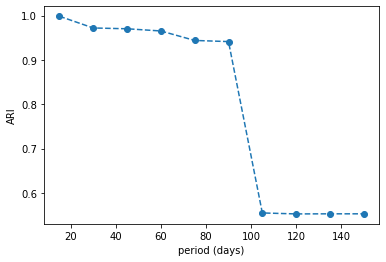

In [16]:
ARI = []
periods = range(15, 160, 15)
for days in periods:
    data_step = database_period(DATA, start=dstart, period=tinit+days)
    data_step = transform_data(data_step)
    #=======================================
    # classification avec le même classifieur
    #=======================================
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    #=======================================
    # classification avec un classifieur mis à jour
    #=======================================
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods,ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

En utilisant des données plus récente, on peut affirmer qu'une mise à jours après 3 mois est suffisante pour assurer une segmentation correcte.

#### Prise en compte d'une longue période comme base de données initiale

In [17]:
tinit = 365
data_init = database_period(DATA, period=tinit)
print(f"Premier jour de la BDD : {data_init['order_purchase_timestamp'].min().date()}")
print(f"Dernier jour de la BDD : {data_init['order_purchase_timestamp'].max().date()}")
data_init = transform_data(data_init)
scaler_init = preprocessing.StandardScaler().fit(data_init)
data_init_norm = scaler_init.transform(data_init)
cls_init = KMeans(n_clusters=3, n_init=50, init='k-means++',random_state=42)
cls_init.fit(data_init_norm)

Premier jour de la BDD : 2016-09-04
Dernier jour de la BDD : 2017-09-04


KMeans(n_clusters=3, n_init=50, random_state=42)

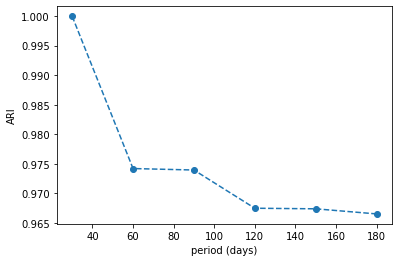

In [20]:
ARI = []
periods = range(30, 200, 30)
for days in periods:
    data_step = database_period(DATA, period=tinit+days)
    data_step = transform_data(data_step)
    #=======================================
    # classification avec le même classifieur
    #=======================================
    data_step_oldnorm = scaler_init.transform(data_step)
    pred_step_no_update = cls_init.predict(data_step_oldnorm)
    #=======================================
    # classification avec un classifieur mis à jour
    #=======================================
    scaler_step = preprocessing.StandardScaler().fit(data_step)
    data_step_norm = scaler_step.transform(data_step)
    cls_step = KMeans(n_clusters=3, n_init=50, init='k-means++', random_state=42)
    cls_step.fit(data_step_norm)
    pred_step_update = cls_step.predict(data_step_norm)
    ARI.append(metrics.adjusted_rand_score(pred_step_no_update, pred_step_update))
fig, ax = plt.subplots()
ax.plot(periods,ARI, linestyle="--", marker="o")
ax.set_xlabel('period (days)')
ax.set_ylabel('ARI')
plt.show()

L'utilisation d'une période initiale plus longue permet de stabiliser sur une longue période la ségmentation.